In [1]:
import simi

import pandas as pd
from sentence_transformers import evaluation, losses, models, InputExample, SentenceTransformer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, BertForMaskedLM, AutoModelForMaskedLM, AutoModel

from tqdm.auto import tqdm
tqdm.pandas()

RANDOM_STATE = 1

#set_seed(RANDOM_STATE)
#enable_full_determinism(RANDOM_STATE)


# SentenceTransformers cosine-similarity scoring for (m)class
def st_similarity_scoring(df, model, append=False, name="cos-sim"):
    scores = df.progress_apply(lambda r: simi.pairwise_cosine_similarity(simi.model_embeddings(model, [r["text_a"], r["text_b"]]))[0][0], axis=1)
    scores = pd.Series(scores, index=df.index, name=name)
    if append:
        return df.merge(scores.to_frame(), left_index=True, right_index=True)
    return scores

2024-01-14 16:59:39.584247: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load and select test data

In [2]:
df = pd.read_csv("class-arxiv-dataset.csv", index_col=0)
df.sample(5)

,label,categories_a,text_a,categories_b,text_b
53164,1,"('stat.ME',)",MSP: A Multi-step Screening Procedure for Spar...,"('stat.ME',)",Interpretable sensitivity analysis for the Bar...
40894,1,"('math.OC',)","Optimal, centralized dynamic curbside parking ...","('math.OC',)",Rhythmic Control of Automated Traffic -- Part ...
34769,0,"('math.NA',)","Implicit-explicit, realizability-preserving fi...","('math.KT',)",On homology of Lie algebras over commutative r...
28991,1,"('math.GR',)",Spaces with labelled partitions and isometric ...,"('math.GR',)",Almost solutions of equations in permutations....
6971,1,"('math.AP',)",Short-time heat content asymptotics via the wa...,"('math.AP',)",Free boundary problems for Tumor Growth: a Vis...


In [3]:
X_treval, X_test = train_test_split(df, train_size=0.9, random_state=RANDOM_STATE)
X_train, X_eval = train_test_split(X_treval, train_size=0.888889, random_state=RANDOM_STATE)
print("train:", len(X_train), "eval:", len(X_eval), "test:", len(X_test))

train: 43572 eval: 5447 test: 5447


## Model definitions

In [4]:
# combine models into dict
eval_models = {
    'SBERT+ANCH-ARX+CLASS-ZBM': SentenceTransformer('./sbert+retrain_anchor_arxiv_class_zbmath'),
    'SBERT+CLASS-ZBM+ANCH-ARX': SentenceTransformer('./sbert+retrain_class_zbmath_anchor_arxiv'),
    'SBERT+CLASS-ARX+CLASS-ZBM+ANCH-ARX': SentenceTransformer('./sbert+retrain_class_arxiv_class_zbmath_anchor_arxiv'),
    'SBERT+ANCH-ARX+CLASS-ARX+CLASS-ZBM': SentenceTransformer('./sbert+retrain_anchor_arxiv_class_arxiv_class_zbmath'),
    'SBERT+CLASS-ARX+ANCH-ARX+CLASS-ZBM': SentenceTransformer('./sbert+retrain_class_arxiv_anchor_arxiv_class_zbmath'),
    
    'SPECTER2+ANCH-ARX+CLASS-ZBM': SentenceTransformer('./specter2+mp+retrain_anchor_arxiv_class_zbmath'),
    'SPECTER2+CLASS-ZBM+ANCH-ARX': SentenceTransformer('./specter2+mp+retrain_class_zbmath_anchor_arxiv'),
    'SPECTER2+CLASS-ARX+CLASS-ZBM+ANCH-ARX': SentenceTransformer('./specter2+mp+retrain_class_arxiv_class_zbmath_anchor_arxiv'),
    'SPECTER2+ANCH-ARX+CLASS-ARX+CLASS-ZBM': SentenceTransformer('./specter2+mp+retrain_anchor_arxiv_class_arxiv_class_zbmath'),
    'SPECTER2+CLASS-ARX+ANCH-ARX+CLASS-ZBM': SentenceTransformer('./specter2+mp+retrain_class_arxiv_anchor_arxiv_class_zbmath'),
    
    'BERT+MLM+ANCH-ARX+CLASS-ZBM': SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_anchor_arxiv_class_zbmath'),
    'BERT+MLM+CLASS-ZBM+ANCH-ARX': SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_zbmath_anchor_arxiv'),
    'BERT+MLM+CLASS-ARX+CLASS-ZBM+ANCH-ARX': SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_arxiv_class_zbmath_anchor_arxiv'),
    'BERT+MLM+ANCH-ARX+CLASS-ARX+CLASS-ZBM': SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_arxiv_anchor_class_arxiv_class_zbmath'),
    'BERT+MLM+CLASS-ARX+ANCH-ARX+CLASS-ZBM': SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_arxiv_anchor_arxiv_class_zbmath'),
}

## Spearman-Pearson-rank-coefficient for test data

In [5]:
eval_examples = X_test.reset_index(drop=True).apply(lambda r: InputExample(texts=[r["text_a"], r["text_b"]], label=r["label"]), axis=1)
evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(eval_examples, batch_size=64, show_progress_bar=True)

In [6]:
%%time
spear_rancs = {}

with tqdm(total=len(eval_models)) as pb:
    for n,m in eval_models.items():
        pb.set_postfix_str("Current model: {}".format(n))
        spear_rancs[n] = [m.evaluate(evaluator)]
        pb.update()
        
spear_ranc_df = pd.DataFrame(spear_rancs)

  0%|          | 0/15 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

CPU times: user 45min 28s, sys: 51.8 s, total: 46min 20s
Wall time: 19min 59s


In [7]:
pd.set_option('display.max_columns', 40)

In [8]:
spear_ranc_df

,SBERT+ANCH-ARX+CLASS-ZBM,SBERT+CLASS-ZBM+ANCH-ARX,SBERT+CLASS-ARX+CLASS-ZBM+ANCH-ARX,SBERT+ANCH-ARX+CLASS-ARX+CLASS-ZBM,SBERT+CLASS-ARX+ANCH-ARX+CLASS-ZBM,SPECTER2+ANCH-ARX+CLASS-ZBM,SPECTER2+CLASS-ZBM+ANCH-ARX,SPECTER2+CLASS-ARX+CLASS-ZBM+ANCH-ARX,SPECTER2+ANCH-ARX+CLASS-ARX+CLASS-ZBM,SPECTER2+CLASS-ARX+ANCH-ARX+CLASS-ZBM,BERT+MLM+ANCH-ARX+CLASS-ZBM,BERT+MLM+CLASS-ZBM+ANCH-ARX,BERT+MLM+CLASS-ARX+CLASS-ZBM+ANCH-ARX,BERT+MLM+ANCH-ARX+CLASS-ARX+CLASS-ZBM,BERT+MLM+CLASS-ARX+ANCH-ARX+CLASS-ZBM
0,0.076263,0.07902,0.784581,0.773427,0.782972,0.38755,0.397091,0.778492,0.77624,0.771699,0.378131,0.393361,0.78583,0.783557,0.785618


In [9]:
X_test_score = X_test.copy()

In [10]:
%%time
with tqdm(total=len(eval_models)) as pb:
    for n,m in eval_models.items():
        pb.set_postfix_str("Current model: {}".format(n))
        X_test_score["cos-sim ({})".format(n)] = st_similarity_scoring(X_test, m)
        pb.update()

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

CPU times: user 2h 3min 44s, sys: 37.7 s, total: 2h 4min 21s
Wall time: 25min 25s


## Results for test data

In [11]:
X_test_score[X_test_score["label"] == 1].describe()

,label,cos-sim (SBERT+ANCH-ARX+CLASS-ZBM),cos-sim (SBERT+CLASS-ZBM+ANCH-ARX),cos-sim (SBERT+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (SBERT+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (SBERT+CLASS-ARX+ANCH-ARX+CLASS-ZBM),cos-sim (SPECTER2+ANCH-ARX+CLASS-ZBM),cos-sim (SPECTER2+CLASS-ZBM+ANCH-ARX),cos-sim (SPECTER2+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (SPECTER2+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (SPECTER2+CLASS-ARX+ANCH-ARX+CLASS-ZBM),cos-sim (BERT+MLM+ANCH-ARX+CLASS-ZBM),cos-sim (BERT+MLM+CLASS-ZBM+ANCH-ARX),cos-sim (BERT+MLM+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (BERT+MLM+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (BERT+MLM+CLASS-ARX+ANCH-ARX+CLASS-ZBM)
count,2766.0,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000
mean,1.0,0.117494,0.113668,0.766772,0.762154,0.768004,0.208894,0.204525,0.756057,0.753192,0.747072,0.245279,0.242151,0.772288,0.769393,0.773113
std,0.0,0.763243,0.796036,0.340722,0.354233,0.349540,0.213445,0.211608,0.380211,0.381127,0.385901,0.257589,0.252879,0.372490,0.372516,0.371866
min,1.0,-0.998083,-0.998957,-0.073380,-0.184438,-0.054899,-0.386692,-0.439323,-0.025249,-0.023236,-0.021340,-0.530608,-0.491091,-0.021007,-0.026987,-0.019586
25%,1.0,-0.684764,-0.789690,0.634484,0.620383,0.643334,0.063792,0.057675,0.542785,0.546497,0.511655,0.055594,0.056410,0.697119,0.667539,0.710917
50%,1.0,0.333380,0.327951,0.968457,0.980393,0.978433,0.204863,0.199241,0.992033,0.990237,0.990586,0.249453,0.247523,0.993919,0.993072,0.994208
75%,1.0,0.979434,0.996384,0.996045,0.997302,0.996893,0.360520,0.352785,0.998668,0.998554,0.998691,0.435954,0.428644,0.998872,0.998737,0.998956
max,1.0,0.999994,0.999993,0.999812,0.999846,0.999754,0.798806,0.801382,0.999909,0.999908,0.999902,0.906705,0.877843,0.999925,0.999936,0.999906


In [12]:
X_test_score[X_test_score["label"] == 0].describe()

,label,cos-sim (SBERT+ANCH-ARX+CLASS-ZBM),cos-sim (SBERT+CLASS-ZBM+ANCH-ARX),cos-sim (SBERT+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (SBERT+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (SBERT+CLASS-ARX+ANCH-ARX+CLASS-ZBM),cos-sim (SPECTER2+ANCH-ARX+CLASS-ZBM),cos-sim (SPECTER2+CLASS-ZBM+ANCH-ARX),cos-sim (SPECTER2+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (SPECTER2+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (SPECTER2+CLASS-ARX+ANCH-ARX+CLASS-ZBM),cos-sim (BERT+MLM+ANCH-ARX+CLASS-ZBM),cos-sim (BERT+MLM+CLASS-ZBM+ANCH-ARX),cos-sim (BERT+MLM+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (BERT+MLM+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (BERT+MLM+CLASS-ARX+ANCH-ARX+CLASS-ZBM)
count,2681.0,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000
mean,0.0,0.014692,0.009091,0.053469,0.047325,0.048167,0.039973,0.033370,0.044342,0.046552,0.045649,0.049655,0.040640,0.039771,0.041672,0.039823
std,0.0,0.690781,0.717720,0.175016,0.175623,0.180353,0.189087,0.186139,0.176584,0.182848,0.180425,0.214833,0.211670,0.168782,0.174981,0.173217
min,0.0,-0.997331,-0.998695,-0.074015,-0.117137,-0.088655,-0.472837,-0.490799,-0.028829,-0.026358,-0.049812,-0.542232,-0.487422,-0.031224,-0.034558,-0.029950
25%,0.0,-0.582977,-0.596580,-0.008266,-0.006304,-0.006215,-0.091030,-0.094964,-0.002193,-0.001896,-0.002030,-0.105966,-0.110417,-0.002469,-0.002472,-0.002711
50%,0.0,0.035316,-0.069551,-0.000357,-0.000862,-0.000421,0.027845,0.022396,0.000257,0.000574,0.000365,0.035507,0.023053,-0.000175,0.000200,-0.000204
75%,0.0,0.554179,0.600745,0.023777,0.009328,0.008868,0.160515,0.150186,0.005379,0.005473,0.005170,0.190820,0.175459,0.003406,0.003947,0.003559
max,0.0,0.999988,0.999978,0.999104,0.998827,0.999024,0.687044,0.756973,0.999535,0.999384,0.999363,0.780988,0.764882,0.999609,0.999227,0.999432


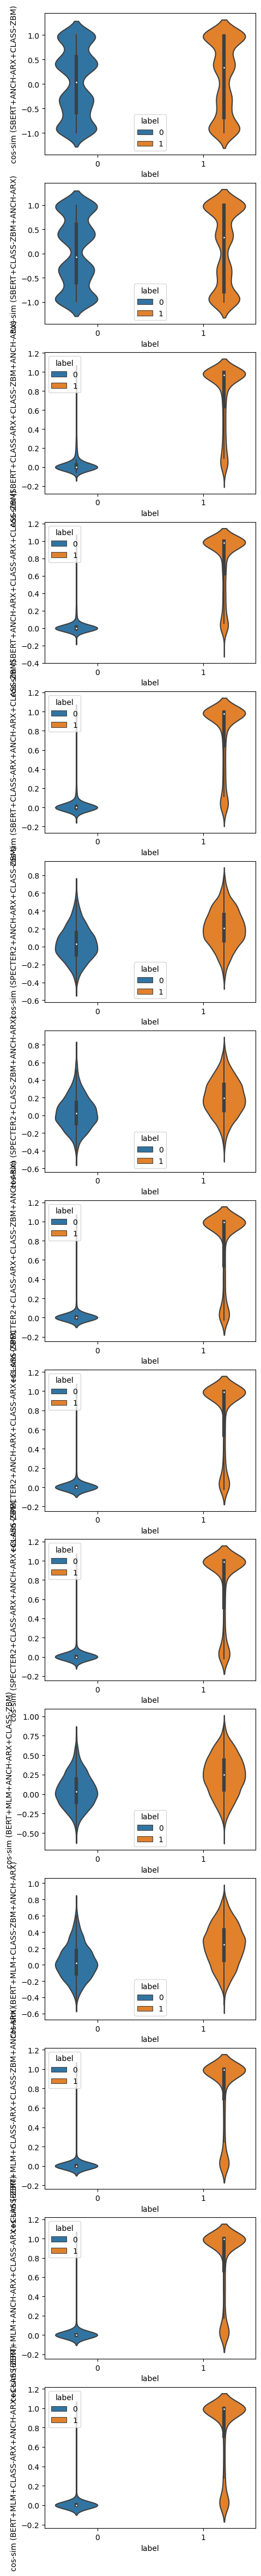

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axs = plt.subplots(len(eval_models), 1, figsize=(5, 4*len(eval_models)))
for i,n in enumerate(eval_models.keys()):
    sns.violinplot(X_test_score, x="label", y="cos-sim ({})".format(n), hue="label", scale="count", scale_hue=True, ax=axs[i])

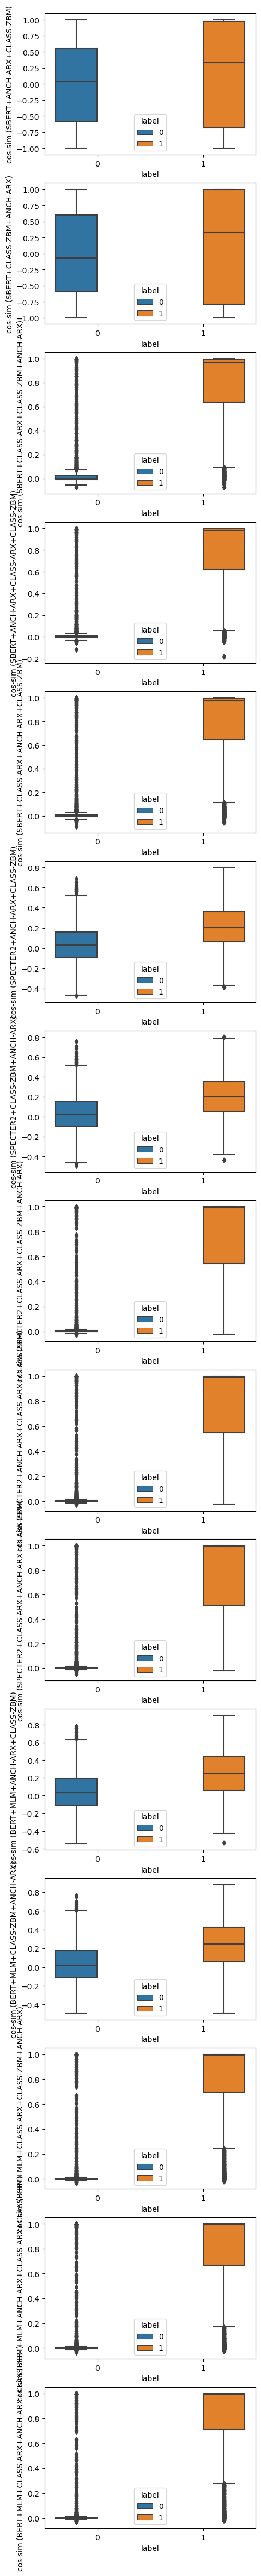

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axs = plt.subplots(len(eval_models), 1, figsize=(5, 4*len(eval_models)))
for i,n in enumerate(eval_models.keys()):
    sns.boxplot(X_test_score, x="label", y="cos-sim ({})".format(n), hue="label", ax=axs[i])

In [15]:
# Die Ergebnisse sehen schon sehr verdächtig aus, müssen wir ggf. Layer freezen? s. https://towardsdatascience.com/what-exactly-happens-when-we-fine-tune-bert-f5dc32885d76
X_test_score.sample(15, random_state=RANDOM_STATE)

,label,categories_a,text_a,categories_b,text_b,cos-sim (SBERT+ANCH-ARX+CLASS-ZBM),cos-sim (SBERT+CLASS-ZBM+ANCH-ARX),cos-sim (SBERT+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (SBERT+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (SBERT+CLASS-ARX+ANCH-ARX+CLASS-ZBM),cos-sim (SPECTER2+ANCH-ARX+CLASS-ZBM),cos-sim (SPECTER2+CLASS-ZBM+ANCH-ARX),cos-sim (SPECTER2+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (SPECTER2+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (SPECTER2+CLASS-ARX+ANCH-ARX+CLASS-ZBM),cos-sim (BERT+MLM+ANCH-ARX+CLASS-ZBM),cos-sim (BERT+MLM+CLASS-ZBM+ANCH-ARX),cos-sim (BERT+MLM+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (BERT+MLM+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (BERT+MLM+CLASS-ARX+ANCH-ARX+CLASS-ZBM)
14175,1,"('math.CO',)",On Weak Chromatic Polynomials of Mixed Graphs....,"('math.CO',)",Projective Equivalences of k-neighbourly Polyt...,-0.249986,-0.313905,0.996810,0.987026,0.996941,0.263059,0.408226,0.999596,0.999565,0.999294,0.088484,0.208214,0.999393,0.999763,0.999194
29240,1,"('math.GR',)",Galois Theory - a first course. These notes ar...,"('math.GR',)",On p-stability in groups and fusion systems. T...,0.998718,0.999642,0.694685,0.647017,0.610932,0.183974,0.218150,0.765526,0.667650,0.118726,0.305005,0.247336,0.593060,0.476002,0.659866
31864,1,"('math.KT',)",Controlled $K$-theory and $K$-Homology. An ope...,"('math.KT',)",Cyclic homology of braided Hopf crossed produc...,-0.970790,-0.959612,0.898660,0.835972,0.936743,0.064095,-0.033938,0.230374,0.981290,0.676030,0.064864,-0.100319,0.927388,0.738166,0.778708
48373,1,"('math.RA',)",Simple subalgebras of simple special Jordan al...,"('math.RA',)",Normalization of Quaternionic Polynomials. Qua...,-0.586703,-0.593883,0.971946,0.939650,0.963368,0.381439,0.562830,0.909348,0.841770,0.758956,0.534718,0.542185,0.895533,0.540379,0.854325
11994,1,"('math.CA',)",On some Hadamard-Type Inequalities for Co-ordi...,"('math.CA',)",Non-differentiable solutions for local fractio...,-0.946937,-0.970204,0.640547,0.721100,0.900836,0.147695,0.272049,0.995041,0.912611,0.988919,0.288283,0.122310,0.704627,0.997312,0.990650
48427,1,"('math.RA',)",Basic superranks for varieties of algebras. We...,"('math.RA',)",A note on solvable maximal subgroups in subnor...,0.999753,0.999935,0.975315,0.994070,0.984811,0.039628,0.062206,0.988532,0.988466,0.998559,0.268852,0.293431,0.989671,0.973416,0.960996
22315,0,"('math.DG',)",Tensor tomography on Cartan-Hadamard manifolds...,"('math.OC',)",A new conical internal evolutive LP algorithm....,0.999865,0.999901,-0.023561,-0.009178,-0.001172,0.097279,-0.043233,-0.000784,-0.002576,-0.000187,0.035507,0.065261,-0.004459,0.000754,0.002660
51367,1,"('stat.AP',)",Data-driven dynamic treatment planning for chr...,"('stat.AP',)",Statistical analysis of stellar evolution. Col...,0.404449,0.512794,0.998158,0.993414,0.976850,0.325826,0.267417,0.998528,0.977144,0.988994,0.028874,-0.006150,0.960500,0.908857,0.979513
39212,0,"('math.NT',)",The distribution of spacings between the fract...,"('math.FA',)",Canonical graph contractions of linear relatio...,0.505807,-0.156412,0.041340,0.000190,0.019344,-0.049450,-0.027447,0.212810,-0.000969,-0.003679,-0.124925,-0.297241,0.011885,0.180146,-0.001208
51254,1,"('stat.AP',)",Bayesian model averaging for mortality forecas...,"('stat.AP',)",Selection of multiple donor gauges via Graphic...,0.998580,0.987929,0.996248,0.999164,0.996836,0.203855,0.158697,0.936490,0.998309,0.993031,0.283198,0.279704,0.946465,0.992210,0.992554
